# All Sites Random Forest
## Notebook #3
* random forest run with the second split of elevation bins (reduced data)
* in this notebook, we are not including the steep lines on the PDP 

created by Cassie Lumbrazo\
date: July 2023\
python environment: **raster**


In [2]:
# import packages 
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr

import copy 
import pickle

In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.model_selection import train_test_split
import pydotplus 
from IPython.display import Image
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

In [4]:
# Try opening 1 at a time, subsampling, then making a tidy dataset and closing
# ds_ce = xr.open_dataset('/home/lumbraca/raster/data/cer_model_cleandata_create_netcdf.nc')
# ds_sr = xr.open_dataset('/home/lumbraca/raster/data/sr_model_cleandata_create_netcdf.nc')
# ds_fl = xr.open_dataset('/home/lumbraca/raster/data/fl_model_cleandata_create_netcdf.nc')

# Sample Dataset First 

#### We want to use a random forest generator to determine what best predictors for snow depth 
* ds.dem
* ds.dah
* ds.dce
* ds.tpi

maybe, 
* ds.slope
* ds.aspect

In [5]:
# decide how big to sample 
sample_number = 10

### Cle Elum Ridge

In [6]:
# Read the dataset 1 at a time
ds = xr.open_dataset('/home/lumbraca/raster/data/cer_model_cleandata_create_netcdf.nc')

# Flatten
ds_snowdepth = ds.snowdepth.values.flatten()
ds_dem = ds.dem.values.flatten()
ds_dah = ds.dah.values.flatten() 
ds_dce = ds.dce.values.flatten()
ds_tpi = ds.tpi.values.flatten() 

ds_dah = ds_dah * 100 # we want to multiply this by 100 to perserve the 2 decimal places for analysis
ds_tpi = ds_tpi * 100 # we want to multiply this by 100 to perserve the 2 decimal places for analysis

# Subsample
num = sample_number

ds_snowdepth = ds_snowdepth[::num] #start:stop:step
ds_dem = ds_dem[::num] 
ds_dce = ds_dce[::num] 
ds_dah = ds_dah[::num] 
ds_tpi = ds_tpi[::num] 

# Create DF for the site 
df_ce = pd.DataFrame({'snowdepth': ds_snowdepth,
                   'dem': ds_dem, 
                   'dah': ds_dah, 
                   'tpi': ds_tpi,
                   'dce': ds_dce})

# random forest cannot have any na values
df_ce.dropna(how='any', inplace=True) # it has to be everything 

# And close the large netcdf 
ds.close()

### Sassie Ridge

In [7]:
# Read the dataset 1 at a time
ds = xr.open_dataset('/home/lumbraca/raster/data/sr_model_cleandata_create_netcdf.nc')

# Flatten
ds_snowdepth = ds.snowdepth.values.flatten()
ds_dem = ds.dem.values.flatten()
ds_dah = ds.dah.values.flatten() 
ds_dce = ds.dce.values.flatten()
ds_tpi = ds.tpi.values.flatten() 

ds_dah = ds_dah * 100 # we want to multiply this by 100 to perserve the 2 decimal places for analysis
ds_tpi = ds_tpi * 100 # we want to multiply this by 100 to perserve the 2 decimal places for analysis

# Subsample
num = sample_number

ds_snowdepth = ds_snowdepth[::num] #start:stop:step
ds_dem = ds_dem[::num] 
ds_dce = ds_dce[::num] 
ds_dah = ds_dah[::num] 
ds_tpi = ds_tpi[::num] 

# Create DF for the site 
df_sr = pd.DataFrame({'snowdepth': ds_snowdepth,
                   'dem': ds_dem, 
                   'dah': ds_dah, 
                   'tpi': ds_tpi,
                   'dce': ds_dce})

# random forest cannot have any na values
df_sr.dropna(how='any', inplace=True) # it has to be everything 

# And close the large netcdf 
ds.close()

### Fish Lake

In [8]:
# Read the dataset 1 at a time
ds = xr.open_dataset('/home/lumbraca/raster/data/fl_model_cleandata_create_netcdf.nc')

# Flatten
ds_snowdepth = ds.snowdepth.values.flatten()
ds_dem = ds.dem.values.flatten()
ds_dah = ds.dah.values.flatten() 
ds_dce = ds.dce.values.flatten()
ds_tpi = ds.tpi.values.flatten() 

ds_dah = ds_dah * 100 # we want to multiply this by 100 to perserve the 2 decimal places for analysis
ds_tpi = ds_tpi * 100 # we want to multiply this by 100 to perserve the 2 decimal places for analysis

# Subsample
num = sample_number

ds_snowdepth = ds_snowdepth[::num] #start:stop:step
ds_dem = ds_dem[::num] 
ds_dce = ds_dce[::num] 
ds_dah = ds_dah[::num] 
ds_tpi = ds_tpi[::num] 

# Create DF for the site 
df_fl = pd.DataFrame({'snowdepth': ds_snowdepth,
                   'dem': ds_dem, 
                   'dah': ds_dah, 
                   'tpi': ds_tpi,
                   'dce': ds_dce})

# random forest cannot have any na values
df_fl.dropna(how='any', inplace=True) # it has to be everything 

# And close the large netcdf 
ds.close()

In [9]:
## Look at any of these datasets to make sure it worked 
# df_ce
# df_fl
# df_sr

### Merge all sites together into 1 dataframe

In [10]:
# merge the dataframes into 1 
df = pd.concat([df_ce, df_sr, df_fl], axis=0)
df

snowdepth          dem        dah         tpi       dce
88289     0.545976   819.582886  -6.947569 -141.727295 -8.430352
88914     0.519857   819.417725  -6.077637 -173.110062 -6.593832
90788     0.899815   820.030823  -5.040730 -205.761093 -9.144000
91413     0.881211   820.017517  -4.691245 -201.752899 -7.315200
92038     0.654621   819.966675 -11.042705 -220.336624 -5.562078
...            ...          ...        ...         ...       ...
5367960   4.004667  1658.413940  11.439165  -85.257019  7.141693
5368690   3.901827  1658.688599  10.046226  -45.071289  7.141693
5370149   3.902571  1658.351440  -0.307817  -10.239502  8.626432
5372338   4.057055  1658.190308   1.732837    1.292664  8.280244
5374527   4.034135  1657.905396  11.824166  -57.119144  5.783173

[6150060 rows x 5 columns]

(810.0, 1780.0)

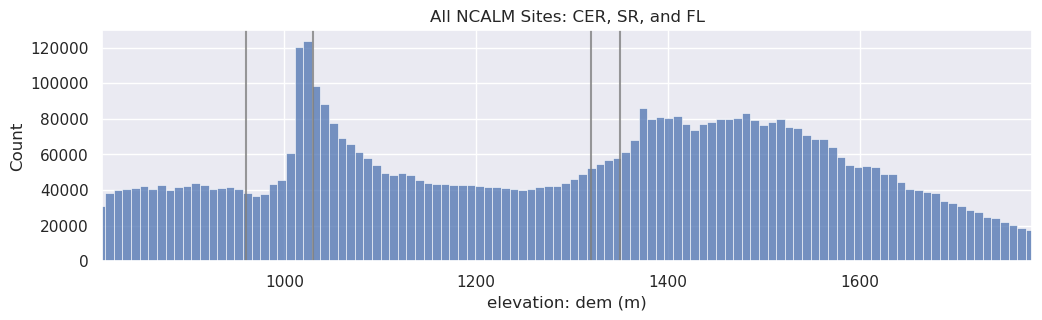

In [11]:
plt.rcParams['figure.figsize'] = [12,3] #overriding size
sns.histplot(data=df['dem'], bins=150)

# the range we are going with, less than 960, between 1030-1320, and greater than 1350

# Setting lines at the split values based on the PP
plt.axvline(x=960,  color='grey', alpha=.8) # trying this range
plt.axvline(x=1030, color='grey', alpha=.8) # trying this range

plt.axvline(x=1320,  color='grey', alpha=.8) # trying this range
plt.axvline(x=1350,  color='grey', alpha=.8) # trying this range

# plt.axvline(x=1100, color='grey',  alpha=.8) # previous value 
# plt.axvline(x=1340, color='grey',  alpha=.8) # previous value 

plt.title('All NCALM Sites: CER, SR, and FL')
plt.xlabel('elevation: dem (m)')
plt.xlim([810, 1780])

## Prepare the dataset for Random Forest Model

In [12]:
df_int = df.copy(deep=True)
df_int['snowdepth'] = df_int['snowdepth'].astype(int)
df_int['dem'] = df_int['dem'].astype(int)
df_int['dah'] = df_int['dah'].astype(int)
df_int['dce'] = df_int['dce'].astype(int)
df_int['tpi'] = df_int['tpi'].astype(int)

df_int.head()

snowdepth  dem  dah  tpi  dce
88289          0  819   -6 -141   -8
88914          0  819   -6 -173   -6
90788          0  820   -5 -205   -9
91413          0  820   -4 -201   -7
92038          0  819  -11 -220   -5

In [13]:
# create the x, variables, columns
X = df_int.drop(columns=['snowdepth'])
X.head()

dem  dah  tpi  dce
88289  819   -6 -141   -8
88914  819   -6 -173   -6
90788  820   -5 -205   -9
91413  820   -4 -201   -7
92038  819  -11 -220   -5

In [14]:
# create the y, predictor, column
y = df_int.snowdepth
y.head()

88289    0
88914    0
90788    0
91413    0
92038    0
Name: snowdepth, dtype: int64

In [15]:
# x.describe()
X.isnull().values.any()
y.isnull().values.any()

False

# Bin Elevation Bands 
Using the bins found above by running the model with and looking at the PP with elevation

In [16]:
# break the data down by elevation bands 
# the range we are going with, less than 960, between 1030-1320, and greater than 1350

df_bin1 = df_int.where(df_int.dem < 960)                          # less than 1300
df_bin2 = df_int.where((df_int.dem >= 1030) & (df_int.dem < 1320)) # greater than or = 1300, less than 1370
df_bin3 = df_int.where(df_int.dem >= 1350)                         # greater than than 1370


# creating bins creates nan, so remove all for random forest 
df_bin1.dropna(how='any', inplace=True) # it has to be everything
df_bin2.dropna(how='any', inplace=True) # it has to be everything 
df_bin3.dropna(how='any', inplace=True) # it has to be everything 

# # 1. THIS SECTION
# # create the x, variables, columns
# X_bin1 = df_bin1.drop(columns=['snowdepth'])
# X_bin2 = df_bin2.drop(columns=['snowdepth'])
# X_bin3 = df_bin3.drop(columns=['snowdepth'])

# 2. OR THIS SECTION, if you want to remove dem from the random forest model 
# create the x, variables, columns
X_bin1 = df_bin1.drop(columns=['snowdepth', 'dem'])
X_bin2 = df_bin2.drop(columns=['snowdepth', 'dem'])
X_bin3 = df_bin3.drop(columns=['snowdepth', 'dem'])

# 3. Then, with either 1 or 2, run 3 
# create the y, predictor, column
y_bin1 = df_bin1.snowdepth
y_bin2 = df_bin2.snowdepth
y_bin3 = df_bin3.snowdepth

In [17]:
# check to make sure.. 
X_bin1.head()

dah    tpi  dce
88289  -6.0 -141.0 -8.0
88914  -6.0 -173.0 -6.0
90788  -5.0 -205.0 -9.0
91413  -4.0 -201.0 -7.0
92038 -11.0 -220.0 -5.0

### Play with decision trees...

Accuracy on train data is 0.47
Accuracy on test data is 0.47


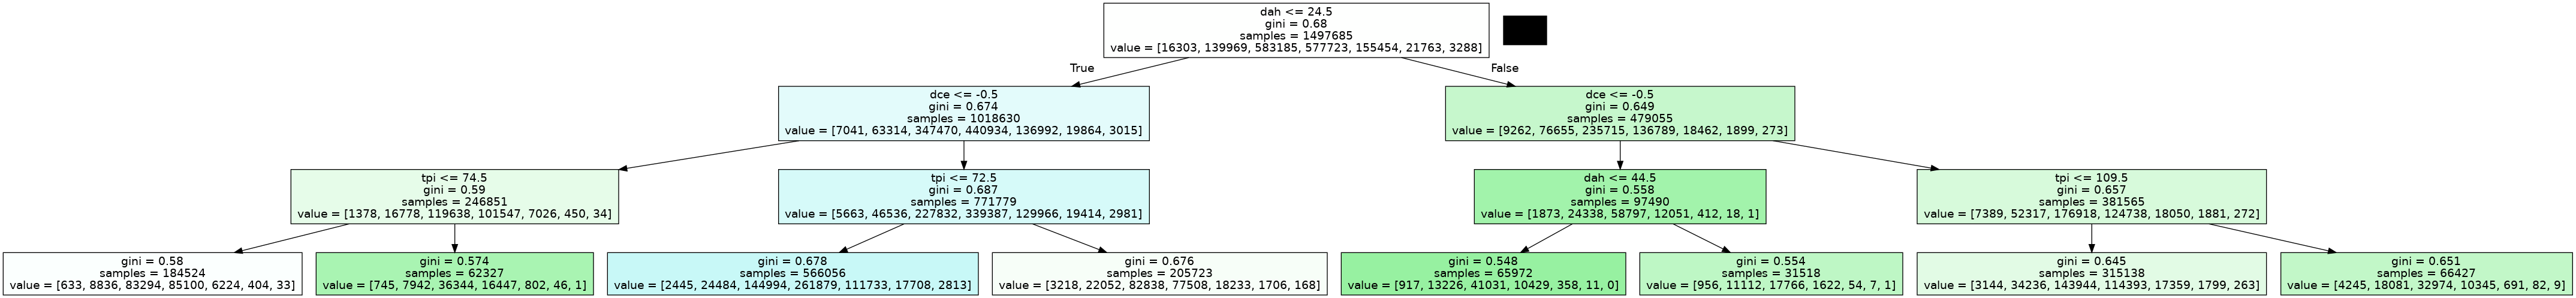

In [18]:
# X_train, X_test, y_train, y_test = train_test_split(X_bin1, y_bin1, test_size=0.5, random_state=0)
# X_train, X_test, y_train, y_test = train_test_split(X_bin2, y_bin2, test_size=0.5, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X_bin3, y_bin3, test_size=0.5, random_state=0)

clf = tree.DecisionTreeClassifier(criterion='gini', max_depth=3)
clf = clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
print('Accuracy on train data is %.2f' % (accuracy_score(y_train, y_pred_train)))

y_pred_test = clf.predict(X_test)
print('Accuracy on test data is %.2f' % (accuracy_score(y_test, y_pred_test)))

dot_data = tree.export_graphviz(clf, feature_names=X_bin1.columns, filled=True, 
                                out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())

## 1.  Random Forest
### Bin 1

In [35]:
number_model_runs = 1000 # for all random forest runs 
# number_model_runs = 50 # for testing right now 

In [36]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_bin1, y_bin1, test_size=0.5, random_state=0)

parameters = {'n_estimators': [number_model_runs], 'max_depth':[3]} # max depth of 3 without elevation
clf1 = GridSearchCV(ensemble.RandomForestClassifier(n_jobs=20), parameters) #cv=3

# trying to write it like this to get the n_jobs parameter to work 
# clf1  = ensemble.RandomForestClassifier(n_estimators=30, max_depth=3, n_jobs=4)

clf1.fit(X=X_train1,y=y_train1.values.ravel())
tree_model1 = clf1.best_estimator_ # only the GridSearchCV has the object "best_estimator_"

y_pred_train1 = tree_model1.predict(X_train1)
y_pred_test1 = tree_model1.predict(X_test1)
print('Accuracy on training data is %.2f' % (accuracy_score(y_train1, y_pred_train1)))
print('Accuracy on test data is %.2f' % (accuracy_score(y_test1, y_pred_test1)))
print(clf1.best_params_)

Accuracy on training data is 0.97
Accuracy on test data is 0.97
{'max_depth': 3, 'n_estimators': 1000}


In [37]:
estimatorAccuracy=[]
for curEstimator in range(number_model_runs):
    estimatorAccuracy.append([curEstimator,accuracy_score(y_bin1.values, tree_model1.estimators_[curEstimator].predict(X_bin1.values))])

estimatorAccuracy=pd.DataFrame(estimatorAccuracy,columns=['estimatorNumber','Accuracy'])
estimatorAccuracy.sort_values(inplace=True,by='Accuracy',ascending=False)

bestDecisionTree1= tree_model1.estimators_[estimatorAccuracy.head(1)['estimatorNumber'].values[0]]

In [38]:
tree.export_graphviz(bestDecisionTree1, out_file='ensemble_tree1.dot', 
                feature_names = X_bin1.columns,
                # class_names = ('no_veg', 'veg'),
                rounded = True, proportion = False, 
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'ensemble_tree1.dot', '-o', 'ensemble_tree1.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'ensemble_tree1.png')

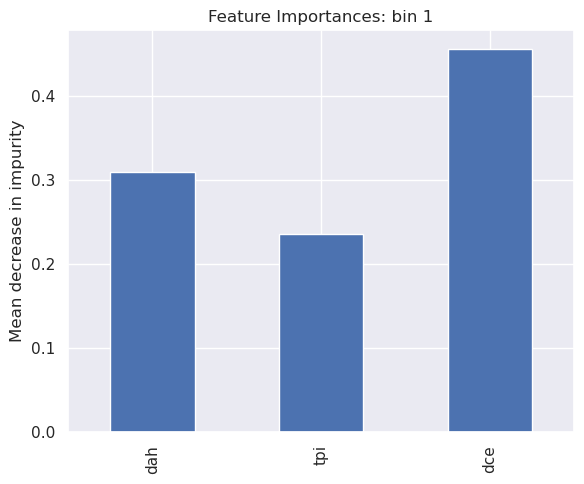

In [39]:
# Feature Importance 
importances1 = tree_model1.feature_importances_
std1 = np.std([tree_model1.feature_importances_ for tree in tree_model1.estimators_], axis=0)

forest_importances1 = pd.Series(importances1, index=X_bin1.columns)

fig, ax = plt.subplots(figsize=(6,5))
forest_importances1.plot.bar(yerr=std1, ax=ax)
ax.set_title("Feature Importances: bin 1")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Bin 2

In [40]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_bin2, y_bin2, test_size=0.5, random_state=0)

parameters = {'n_estimators': [number_model_runs], 'max_depth':[3]} # max depth of 3 without elevation  n_jobs=-1
clf2 = GridSearchCV(ensemble.RandomForestClassifier(n_jobs=20), parameters) #cv=3

# trying to write it like this to get the n_jobs parameter to work 
# clf2  = ensemble.RandomForestClassifier(n_estimators=100, max_depth=3, n_jobs=4)

clf2.fit(X=X_train2,y=y_train2.values.ravel())
tree_model2 = clf2.best_estimator_

y_pred_train2 = tree_model2.predict(X_train2)
y_pred_test2 = tree_model2.predict(X_test2)
print('Accuracy on training data is %.2f' % (accuracy_score(y_train2, y_pred_train2)))
print('Accuracy on test data is %.2f' % (accuracy_score(y_test2, y_pred_test2)))
print(clf2.best_params_)

Accuracy on training data is 0.54
Accuracy on test data is 0.54
{'max_depth': 3, 'n_estimators': 1000}


In [41]:
estimatorAccuracy=[]
for curEstimator in range(number_model_runs):
    estimatorAccuracy.append([curEstimator,accuracy_score(y_bin2.values, tree_model2.estimators_[curEstimator].predict(X_bin2.values))])

estimatorAccuracy=pd.DataFrame(estimatorAccuracy,columns=['estimatorNumber','Accuracy'])
estimatorAccuracy.sort_values(inplace=True,by='Accuracy',ascending=False)

bestDecisionTree2= tree_model2.estimators_[estimatorAccuracy.head(1)['estimatorNumber'].values[0]]

In [42]:
tree.export_graphviz(bestDecisionTree2, out_file='ensemble_tree2.dot', 
                feature_names = X_bin2.columns,
                # class_names = ('no_veg', 'veg'),
                rounded = True, proportion = False, 
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'ensemble_tree2.dot', '-o', 'ensemble_tree2.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'ensemble_tree2.png')

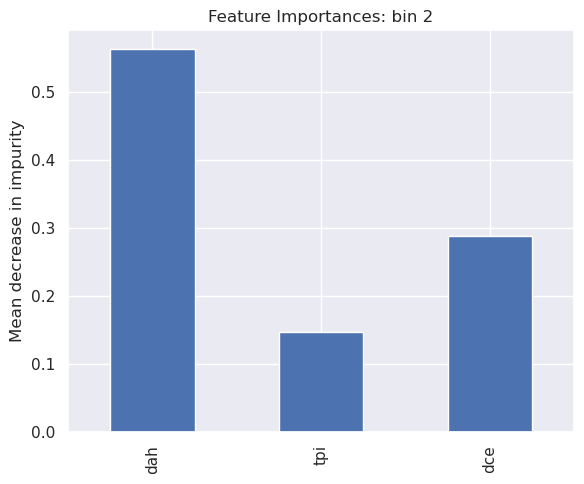

In [43]:
# Feature Importance 
importances2 = tree_model2.feature_importances_
std2 = np.std([tree_model2.feature_importances_ for tree in tree_model2.estimators_], axis=0)

forest_importances2 = pd.Series(importances2, index=X_bin2.columns)

fig, ax = plt.subplots(figsize=(6,5))
forest_importances2.plot.bar(yerr=std2, ax=ax)
ax.set_title("Feature Importances: bin 2")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Bin 3

In [44]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_bin3, y_bin3, test_size=0.5, random_state=0)

parameters = {'n_estimators': [number_model_runs], 'max_depth':[3]} # max depth of 3 without elevation  n_jobs=-1
clf3 = GridSearchCV(ensemble.RandomForestClassifier(n_jobs=20), parameters) #cv=3

# trying to write it like this to get the n_jobs parameter to work 
# clf3  = ensemble.RandomForestClassifier(n_estimators=100, max_depth=3, n_jobs=4)

clf3.fit(X=X_train3,y=y_train3.values.ravel())
tree_model3 = clf3.best_estimator_

y_pred_train3 = tree_model3.predict(X_train3)
y_pred_test3 = tree_model3.predict(X_test3)
print('Accuracy on training data is %.2f' % (accuracy_score(y_train3, y_pred_train3)))
print('Accuracy on test data is %.2f' % (accuracy_score(y_test3, y_pred_test3)))
print(clf3.best_params_)

Accuracy on training data is 0.48
Accuracy on test data is 0.48
{'max_depth': 3, 'n_estimators': 1000}


In [45]:
estimatorAccuracy=[]
for curEstimator in range(number_model_runs):
    estimatorAccuracy.append([curEstimator,accuracy_score(y_bin3.values, tree_model3.estimators_[curEstimator].predict(X_bin3.values))])

estimatorAccuracy=pd.DataFrame(estimatorAccuracy,columns=['estimatorNumber','Accuracy'])
estimatorAccuracy.sort_values(inplace=True,by='Accuracy',ascending=False)

bestDecisionTree3= tree_model3.estimators_[estimatorAccuracy.head(1)['estimatorNumber'].values[0]]

In [46]:
tree.export_graphviz(bestDecisionTree3, out_file='ensemble_tree3.dot', 
                feature_names = X_bin3.columns,
                # class_names = ('no_veg', 'veg'),
                rounded = True, proportion = False, 
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'ensemble_tree3.dot', '-o', 'ensemble_tree3.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'ensemble_tree3.png')

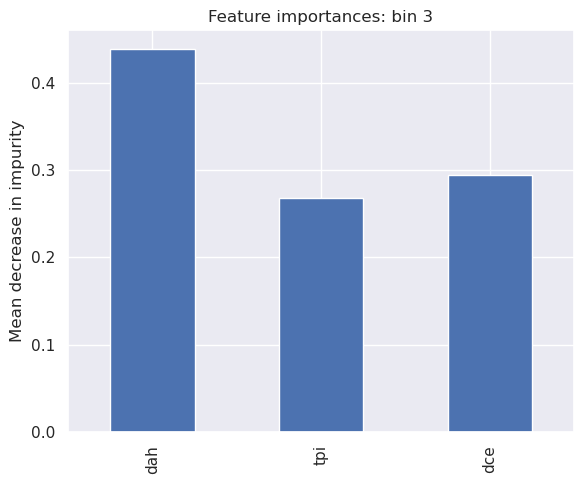

In [47]:
# Feature Importance 
importances3 = tree_model3.feature_importances_
std3 = np.std([tree_model3.feature_importances_ for tree in tree_model3.estimators_], axis=0)

forest_importances3 = pd.Series(importances3, index=X_bin3.columns)

fig, ax = plt.subplots(figsize=(6,5))
forest_importances3.plot.bar(yerr=std3, ax=ax)
ax.set_title("Feature importances: bin 3")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## All Bins Together

Text(0, 0.5, 'Mean decrease in impurity')

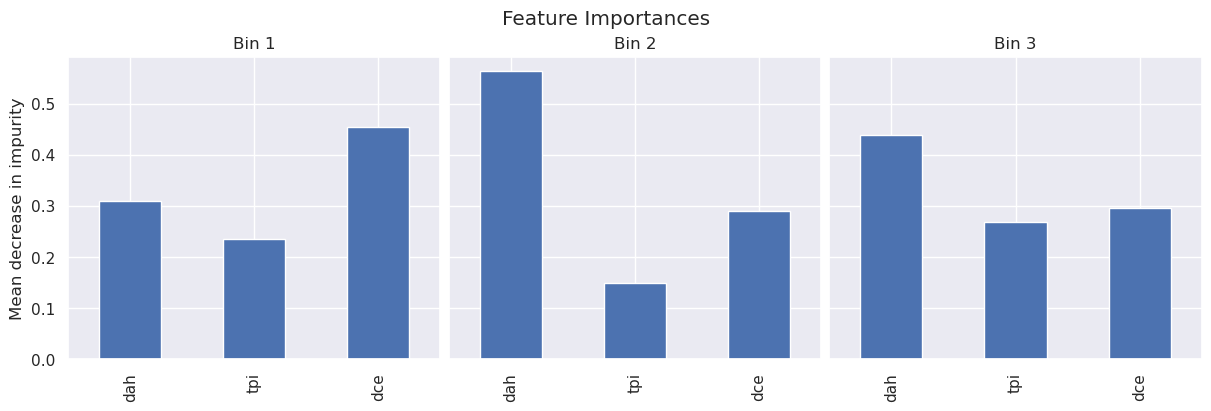

In [48]:
# Figure for all three bins
fig, axes = plt.subplots(1,3, figsize=(12,4), constrained_layout = True, sharex=True, sharey=True)
forest_importances1.plot.bar(yerr=std1, ax=axes[0])
forest_importances2.plot.bar(yerr=std2, ax=axes[1])
forest_importances3.plot.bar(yerr=std3, ax=axes[2])

fig.suptitle("Feature Importances")

axes[0].set_title("Bin 1")
axes[1].set_title("Bin 2")
axes[2].set_title("Bin 3")

axes[0].set_ylabel("Mean decrease in impurity")


In [49]:
# try to combine the data so that we can put the bar charts together 
d = {'dah': [forest_importances1.dah, forest_importances2.dah, forest_importances3.dah], 
    'tpi': [forest_importances1.tpi, forest_importances2.tpi, forest_importances3.tpi], 
    'dce': [forest_importances1.dce, forest_importances2.dce, forest_importances3.dce]}

In [50]:
d

{'dah': [0.30963220798717883, 0.563072044244405, 0.4378690589555754],
 'tpi': [0.23524463309015714, 0.1479759097081416, 0.26739787690988065],
 'dce': [0.45512315892266403, 0.2889520460474534, 0.2947330641345441]}

In [51]:
modeled_df = pd.DataFrame(data=d, index=['bin1', 'bin2', 'bin3'])

In [52]:
modeled_df

dah       tpi       dce
bin1  0.309632  0.235245  0.455123
bin2  0.563072  0.147976  0.288952
bin3  0.437869  0.267398  0.294733

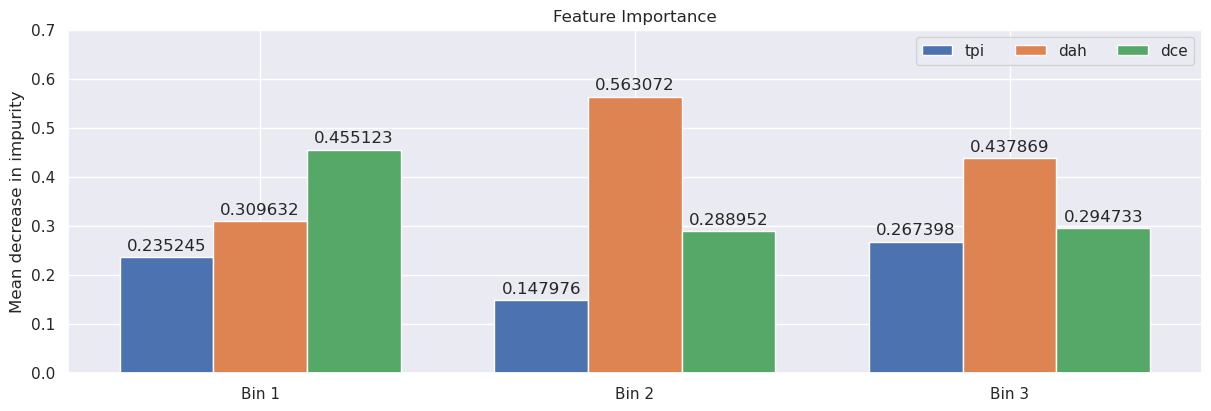

In [53]:
species = ("Bin 1", "Bin 2", "Bin 3")
penguin_means = {
    'tpi': (forest_importances1.tpi, forest_importances2.tpi, forest_importances3.tpi),
    'dah': (forest_importances1.dah, forest_importances2.dah, forest_importances3.dah),
    'dce': (forest_importances1.dce, forest_importances2.dce, forest_importances3.dce),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean decrease in impurity')
ax.set_title('Feature Importance')
ax.set_xticks(x + width, species)
ax.legend(loc='upper right', ncols=3)
ax.set_ylim(0, 0.7)

plt.show()

# Save the model simulations for later 

In [54]:
filename = 'randomforest_bin1_1000.pkl'
pickle.dump(clf1, open(filename, 'wb')) # wb, writing 

filename = 'randomforest_bin2_1000.pkl'
pickle.dump(clf2, open(filename, 'wb')) # wb, writing

filename = 'randomforest_bin3_1000.pkl'
pickle.dump(clf3, open(filename, 'wb')) # wb, writing

# loaded_model = pickle.load(open(filename, 'rb')) # rb, reading 
# result = loaded_model.score(X_test, y_test)
# print(result)

### Moving to the AllSites_RandomForest_4 notebook to make plots of the results from this notebook.